In [1]:
import healpy as hp
import numpy as np
from astropy import units as u
import os
from matplotlib import pyplot as plt
import pymaster as nmt

# Util functions

In [ ]:
def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map


def arcmin2rad(arcmin):
    return arcmin * np.pi / 180 / 60

def compute_power_spectrum(map1, ellmax, map2 = None, fsky = None):
    if map2 is not None:
        cl = hp.anafast(map1, map2, lmax= ellmax)
    else:
        cl = hp.anafast(map1, lmax= ellmax)
    if fsky is not None:
        cl /= fsky
    return cl

def normalize_cl(cl, ells = None):
    if ells is None:
        ells = np.arange(len(cl))
    return cl *(ells * (ells + 1))/ (2*np.pi )

In [3]:
def plot_power_spectrum(ells, dls, labels, title, ymax=None, xlabel=None, ylabel=None, linewidth=None, alpha=None):
    ymax = ymax if ymax is not None else 1e4
    xlabel = xlabel if xlabel is not None else r'$\ell$'
    ylabel = ylabel if ylabel is not None else r'$D_{\ell}$'
    linewidth = linewidth if linewidth is not None else .5
    alpha = alpha if alpha is not None else .5

    plt.figure(figsize=(8, 6))
    for dl, label in zip(dls, labels):
        plt.plot(ells, dl, label='Power Spectrum for ' + label, linewidth=linewidth, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, ymax)
    plt.legend()
    plt.show()

def scatter_plot_power_spectrum(ells, dls, labels, title, s = None, ymax=None, xlabel=None, ylabel=None, linewidth=None, alpha=None):
    s = s if s is not None else 1
    ymax = ymax if ymax is not None else 1e4
    xlabel = xlabel if xlabel is not None else r'$\ell$'
    ylabel = ylabel if ylabel is not None else r'$D_{\ell}$'
    linewidth = linewidth if linewidth is not None else .5
    alpha = alpha if alpha is not None else .5

    plt.figure(figsize=(8, 6))
    for dl, label in zip(dls, labels):
        plt.scatter(ells, dl, s= s,label='Power Spectrum for ' + label, linewidth=linewidth, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, ymax)
    plt.legend()
    plt.show()

def combined_power_spectrum_plot(ells, dls_line, dls_scatter, labels_line, labels_scatter, 
                                 title, ymax=None, linewidth=None, alpha=None, s = None,colors_line=None, colors_scatter=None):
    s = s if s is not None else 2
    ymax = ymax if ymax is not None else 1e4
    linewidth = linewidth if linewidth is not None else 1.5
    alpha = alpha if alpha is not None else 1.0
    colors_line = colors_line if colors_line is not None else ['tab:blue', 'tab:green', 'tab:red']
    colors_scatter = colors_scatter if colors_scatter is not None else ['tab:orange', 'tab:purple', 'tab:brown']

    plt.figure(figsize=(8, 6))
    
    # Line Plots
    for dl, label, color in zip(dls_line, labels_line, colors_line):
        plt.plot(ells, dl, label=f'Power Spectrum for {label}', linewidth=linewidth, alpha=alpha, color=color)
    
    # Scatter Plots
    for dl, label, color in zip(dls_scatter, labels_scatter, colors_scatter):
        plt.scatter(ells, dl, label=f'Power Spectrum for {label}', s=s, alpha=alpha, color=color)
    
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$D_{\ell}$')
    plt.title(title)
    plt.ylim(0, ymax)
    plt.legend()
    plt.show()

# Resolution parameters

In [ ]:
nside = 512
ellmax = 2*nside
ells = np.arange(ellmax + 1)

# Mask and fraction of sky

In [5]:
mask_path = '/shared/data/Datasets/I_512_1450_variance_noise/Simulation_Mask/mask.fits'
mask = hp.read_map(mask_path)
fsky = np.sum(mask**2)/len(mask)

# Beam

In [ ]:
beam_fwhm = 20.6 # arcmin
beam_fwhm = arcmin2rad(beam_fwhm)
beam = hp.gauss_beam(beam_fwhm, lmax=ellmax)

## 1. CMB realisation and NILC prediction

## (a) Load maps

In [ ]:
#Test set path
realisation_test_path = '/shared/data/Datasets/I_512_1450/Simulation/Test/'
prediction_test_path = '/shared/data/Datasets/I_512_1450/PyILC_CNILC/NILC_B_Predict/Test/'

In [ ]:
sim_num = 0

# CMB realisation map
cmb_real_path = realisation_test_path + f'sim0{sim_num:03d}/cmb_map_fid.fits'

# NILC prediction map
cmb_pred_path = prediction_test_path + f'sim0{sim_num:03d}/cmb_pred.fits'

In [9]:
cmb_real = hp.read_map(cmb_real_path)
cmb_pred = hp.read_map(cmb_pred_path)

### (b) Remove monopole and dipole

In [10]:
# Remove monopole
cmb_real = hp.remove_monopole(cmb_real)
cmb_pred = hp.remove_monopole(cmb_pred)

# Remove dipole
cmb_real = hp.remove_dipole(cmb_real)
cmb_pred = hp.remove_dipole(cmb_pred)

### (c) Apply mask

In [11]:
# Masked fiducial map
cmb_real_masked = apply_mask(cmb_real,mask)

# Masked prediction map
cmb_pred_masked = apply_mask(cmb_pred,mask)

### (d) Calculate Power spectrum

In [12]:
cl_real = compute_power_spectrum(cmb_real_masked, ellmax, fsky = fsky)

cl_pred = compute_power_spectrum(cmb_pred_masked, ellmax, fsky = fsky)

### (e) Deconvolve the beam

In [ ]:
cl_pred_beam = cl_pred/ beam**2

### (f) Normalize the power spectrum

In [14]:
dl_real = normalize_cl(cl_real)

dl_pred_beam = normalize_cl(cl_pred_beam)

### (g) Visualization

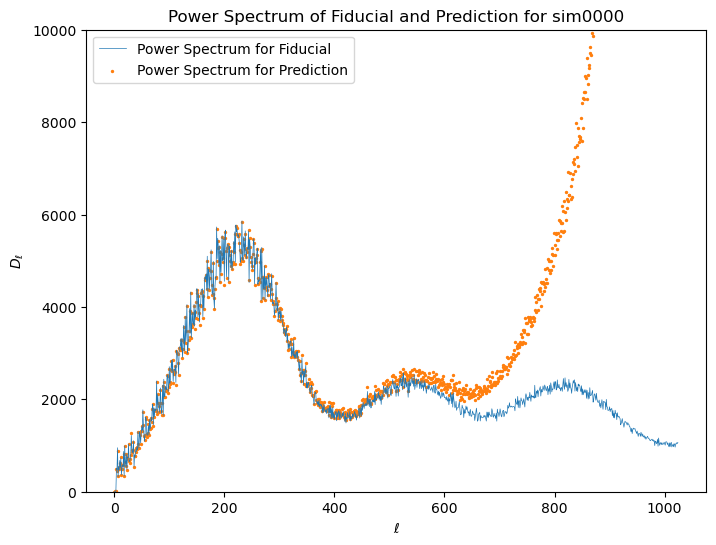

In [15]:
combined_power_spectrum_plot(
    ells=ells,
    dls_line=[dl_real],
    dls_scatter=[dl_pred_beam],
    labels_line=['Fiducial'],
    labels_scatter=['Prediction'],
    title=f"Power Spectrum of Fiducial and Prediction for sim{sim_num:04d}",
    linewidth=0.5,
    alpha=1,
    s = 2
)

## 2. Estimate noise bias

### (a) Load weighted noise maps

In [ ]:
noise_res_dir = '/home/yunan/pyilc/output/new_noise_test/' 

In [17]:
cl_noise_preds_md = []
for i in range(100):
    noise_res_fn = noise_res_dir + f'sim{sim_num:03d}/CN_needletILCmap_component_CMB_noise_res.fits'
    noise_res = hp.read_map(noise_res_fn) / 1e6
    noise_res = hp.remove_monopole(noise_res)
    noise_res = hp.remove_dipole(noise_res)
    noise_res_masked = apply_mask(noise_res, mask)
    cl_noise_res = compute_power_spectrum(noise_res_masked, ellmax, fsky = fsky)
    cl_noise_preds_md.append(cl_noise_res)

In [ ]:
dl_noise_preds_md = []
for cl_noise_pred in cl_noise_preds_md:
    cl_noise_pred_beam = cl_noise_pred/ beam**2
    dl_noise_pred_beam = ells * (ells + 1) * cl_noise_pred_beam / 2 / np.pi
    dl_noise_preds_md.append(dl_noise_pred_beam)

dl_noise_pred_avg_md = np.mean(dl_noise_preds_md, axis=0)

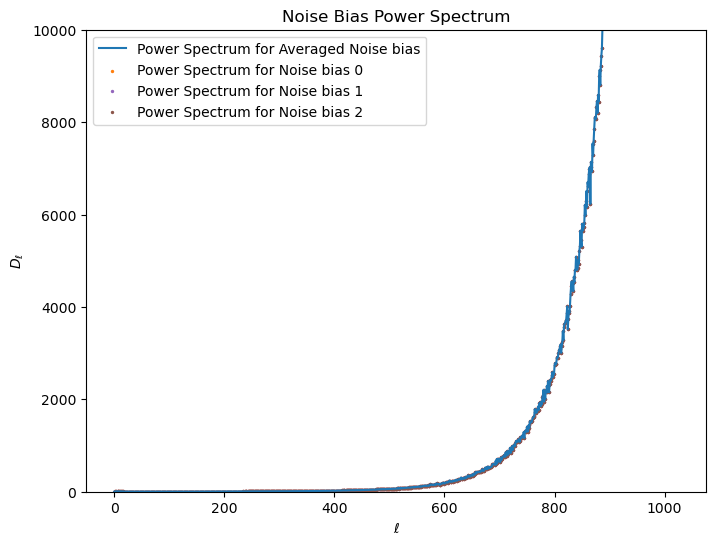

In [19]:
combined_power_spectrum_plot(ells,
                             [dl_noise_pred_avg_md],
                             dl_noise_preds_md,
                            ['Averaged Noise bias'],
                            [f'Noise bias {i}' for i in range(100)],
                            'Noise Bias Power Spectrum',
                            s=2)

## 3. Remove noise bias

In [ ]:
dl_pred_beam_noise = dl_pred_beam - dl_noise_pred_avg_md

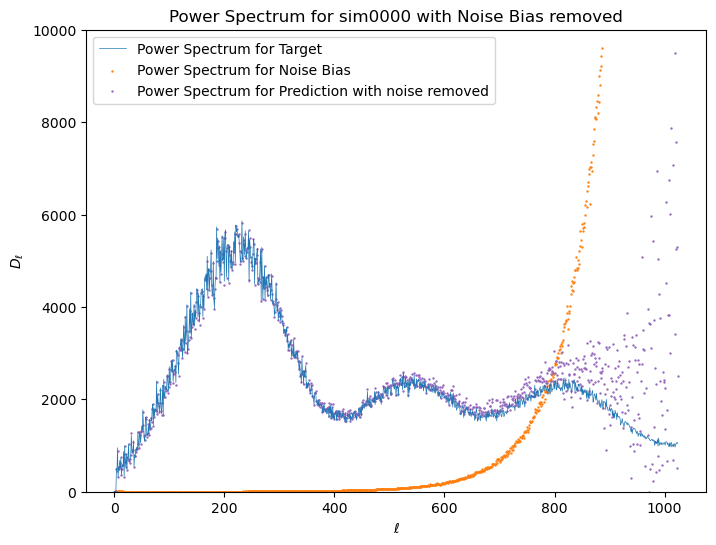

In [21]:
combined_power_spectrum_plot(ells,
                            [dl_real],
                            [dl_noise_pred_avg_md, dl_pred_beam_noise],
                            ['Target'],
                            ['Noise Bias', 'Prediction with noise removed'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias removed',
                            linewidth=0.5,
                            alpha=1,
                            s=0.5)

## 4. Estimate foreground bias

### (a) Load foreground weighted maps and apply mask

In [ ]:
fg_working_dir = '/home/yunan/pyilc/output/foreground/combined/'

In [23]:
combined_fg_maps = []
for sim_num in range(100):
    fn = fg_working_dir + f'sim{sim_num:03d}/CN_needletILCmap_component_CMB_foreground_res.fits'
    map = hp.read_map(fn)
#### Remove monopole and dipole    
    map = hp.remove_monopole(map)
    map = hp.remove_dipole(map)
#### Remove monopole and dipole end
    map_masked = apply_mask(map, mask)
    combined_fg_maps.append(map_masked)

### (b) Calculate power spectrum and correct for fraction of sky

In [24]:
combined_fg_cls_md = []
for map in combined_fg_maps:
    cl = compute_power_spectrum(map, ellmax, fsky = fsky)
    combined_fg_cls_md.append(cl)

### (c) Deconvolve and normalize

In [ ]:
dl_combined_fg_md = []
for cl in combined_fg_cls_md:
    cl_beam = cl / beam**2
    dl = normalize_cl(cl_beam)
    dl_combined_fg_md.append(dl)
dl_combined_fg_avg_md = np.mean(dl_combined_fg_md, axis=0)

### (d) Visualize

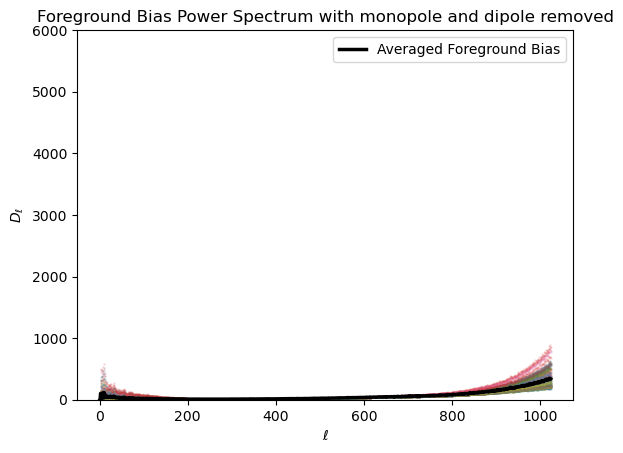

In [26]:
plt.plot(ells, dl_combined_fg_avg_md, label='Averaged Foreground Bias', c = 'black',linewidth=2.5, alpha=1)
for fg_dl in dl_combined_fg_md:
    plt.scatter(ells, fg_dl, s=0.5, alpha=0.15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.ylim(0, 6e3)
plt.title('Foreground Bias Power Spectrum with monopole and dipole removed')
plt.legend()
plt.show()

## 5. Remove foreground bias

In [ ]:
bias_to_be_removed = dl_pred_beam_noise - dl_real

In [ ]:
bias_res = bias_to_be_removed - dl_combined_fg_avg_md

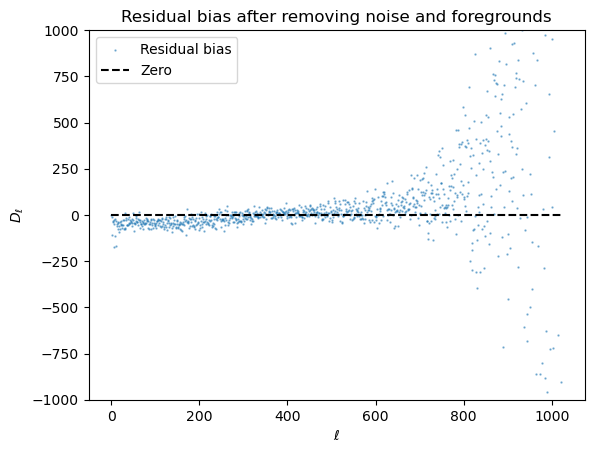

In [29]:
plt.scatter(ells, bias_res, label='Residual bias', s=0.5, alpha=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title('Residual bias after removing noise and foregrounds')
plt.ylim(-1e3, 1e3)
plt.hlines(0, 0, ells[-1], colors='black', linestyles='dashed', label='Zero', linewidth=1.5)
plt.legend()
plt.show()

In [ ]:
dl_pred_beam_noise_combined = dl_pred_beam - dl_noise_pred_avg_md - dl_combined_fg_avg_md

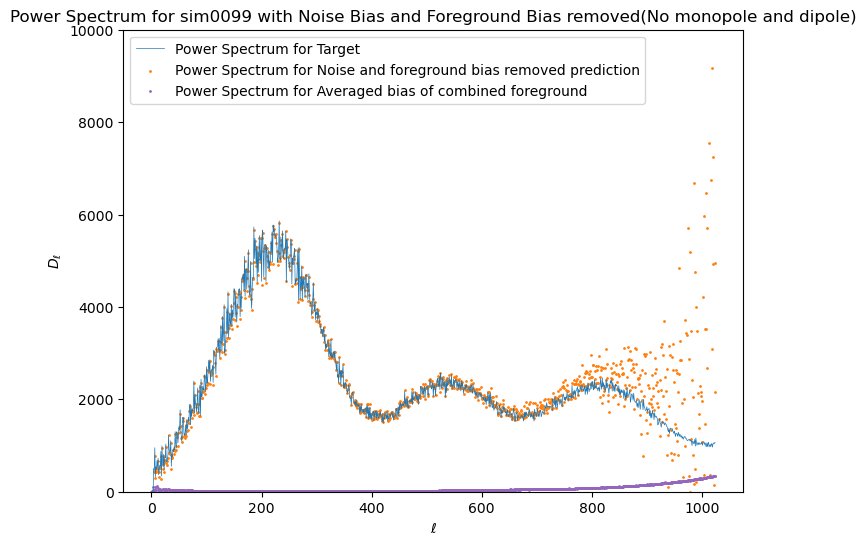

In [31]:
combined_power_spectrum_plot(ells,
                            [dl_real],
                            [dl_pred_beam_noise_combined,dl_combined_fg_avg_md],
                            ['Target'],
                            ['Noise and foreground bias removed prediction', 'Averaged bias of combined foreground'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias and Foreground Bias removed(No monopole and dipole)',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

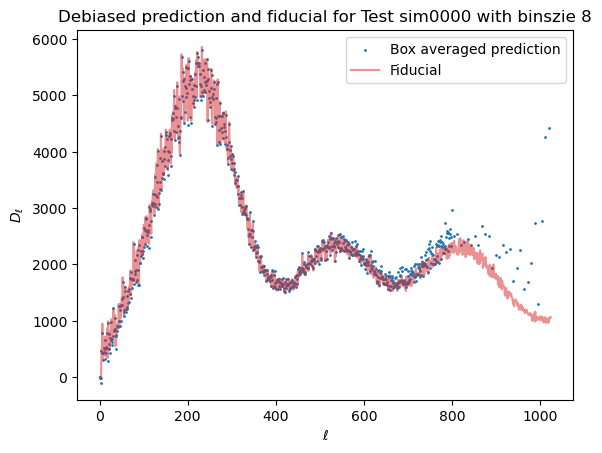

In [32]:
boxsize = 8
box_init = 800
ellmax = len(ells)  # Assuming ellmax is determined from the length of ells
box_num = (ellmax - box_init) // boxsize
box_cart_dl = []
ell_cart = list(np.copy(ells[:box_init]))
box_cart_dl = list(np.copy(dl_pred_beam_noise_combined[:box_init]))

for i in range(box_num):
    box_start = box_init + i * boxsize
    box_end = box_init + (i + 1) * boxsize
    box_ell = np.mean(ells[box_start:box_end])
    box_dl = np.mean(dl_pred_beam_noise_combined[box_start:box_end])
    box_cart_dl.append(box_dl)
    ell_cart.append(box_ell)

plt.scatter(ell_cart, box_cart_dl, s = 1 ,label='Box averaged prediction', color='tab:blue')
plt.plot(ells, dl_real, label='Fiducial', color='tab:red', alpha = 0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title(f'Debiased prediction and fiducial for Test sim0000 with binszie {boxsize}')
plt.legend()
plt.show()

### Outliter in the ensemble

In [33]:
highest_instance = np.argmax([np.max(arr) for arr in dl_combined_fg_md])
print(f'Highest instance: {highest_instance}')

Highest instance: 63


In [ ]:
dl_pred_beam_noise_combined_test = dl_pred_beam - dl_noise_pred_avg_md - dl_combined_fg_avg_md
dl_pred_beam_noise_combined_test_max = dl_pred_beam - dl_noise_pred_avg_md - dl_combined_fg_md[highest_instance]

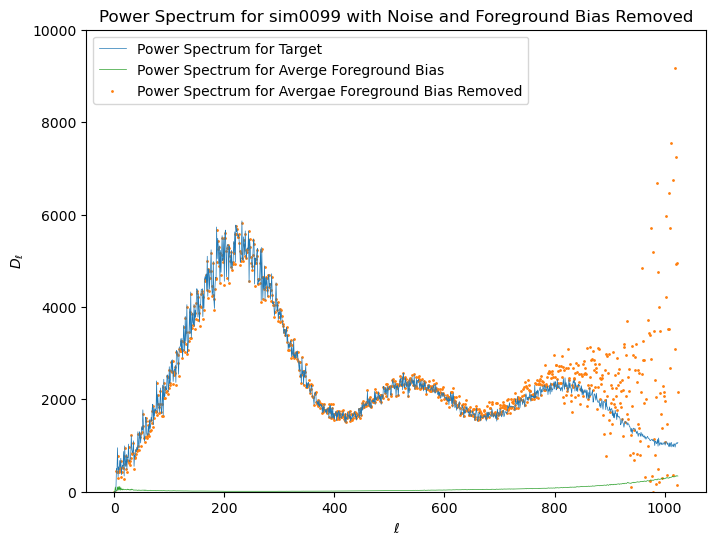

In [35]:
combined_power_spectrum_plot(ells,
                            [dl_real, dl_combined_fg_avg_md],
                            [dl_pred_beam_noise_combined_test],
                            ['Target',  'Averge Foreground Bias'],
                            ['Avergae Foreground Bias Removed'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise and Foreground Bias Removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

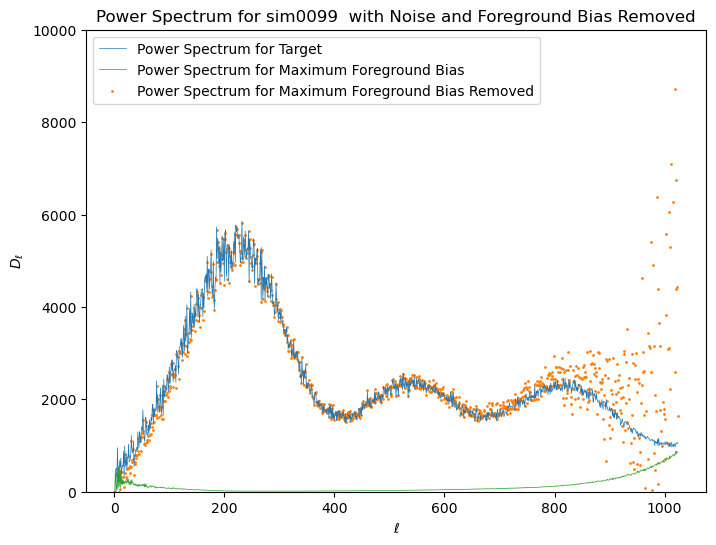

In [36]:
combined_power_spectrum_plot(ells,
                            [dl_real, dl_combined_fg_md[highest_instance]],
                            [dl_pred_beam_noise_combined_test_max],
                            ['Target',  'Maximum Foreground Bias'],
                            ['Maximum Foreground Bias Removed'],
                            f'Power Spectrum for sim{sim_num:04d}  with Noise and Foreground Bias Removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)